In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install langid
!pip install google_trans_new

     |████████████████████████████████| 1.9 MB 2.0 MB/s 
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941188 sha256=455e515c2c5f1b7b74dd1276aa3db8b37f277d1e21a279b7cf7a455dbb0a0472
  Stored in directory: /root/.cache/pip/wheels/2b/bb/7f/11e4db39477278161e882eadc46fb558949a28b13470fc74b8
Successfully built langid


In [3]:
import string
import re
import copy
import langid
from wordcloud import WordCloud, STOPWORDS
from google_trans_new import google_translator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df_ticket_assignment = pd.read_excel("https://github.com/nulilakshman/Automatic-Ticket-Assignment/blob/main/input_data.xlsx?raw=true")

In [5]:
df_ticket_assignment.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [6]:
df_ticket_assignment.shape

(8500, 4)

In [7]:
df_ticket_assignment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


### Observation:
There are 4 columns and all are string columns

* There are totally 8500 rows and there seems to be mising values in Short description and Description columns, which needs to be looked into and handled
* Caller columns mainly contains the details of the user who raised the incident and is of not much use in our analysis and can be dropped.
* Assignment group is our predictor / target column with multiple classes.

This is a Multiclass Classification problem


In [8]:
df_incidents = df_ticket_assignment.drop('Caller',axis=1)

In [9]:
df_incidents.columns

Index(['Short description', 'Description', 'Assignment group'], dtype='object')

In [10]:
df_incidents.describe()

,Short description,Description,Assignment group
count,8492,8499,8500
unique,7481,7817,74
top,password reset,the,GRP_0
freq,38,56,3976


In [11]:
df_incidents['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [12]:
len(df_incidents['Assignment group'].unique())

74

In [13]:
df_inc = df_incidents['Assignment group'].value_counts().reset_index()
df_inc['percentage'] = (df_inc['Assignment group']/df_inc['Assignment group'].sum())*100
df_inc.head()

,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


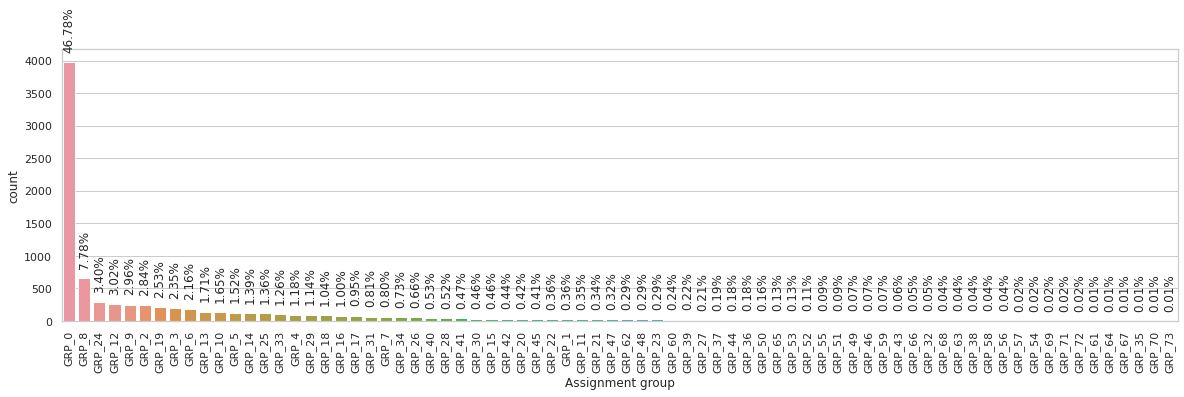

In [14]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=df_incidents, order=df_incidents["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(df_incidents.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

### Observation
* This is a imbalanced dataset, with majority of incidents are from Group 0 followed by Group 8 , 24 , 12 , 9 , 2 and so on
* There are few classes which just have less 10 incidents pers class and even classed with just 1 or 2 incidents, need to see if we can drop those rows due to the lack of samples representing those classes. They might not be of much help as a predictor

In [15]:
df_top_20 = df_incidents['Assignment group'].value_counts().nlargest(20).reset_index()
df_top_20

,index,Assignment group
0,GRP_0,3976
1,GRP_8,661
2,GRP_24,289
3,GRP_12,257
4,GRP_9,252
5,GRP_2,241
6,GRP_19,215
7,GRP_3,200
8,GRP_6,184
9,GRP_13,145


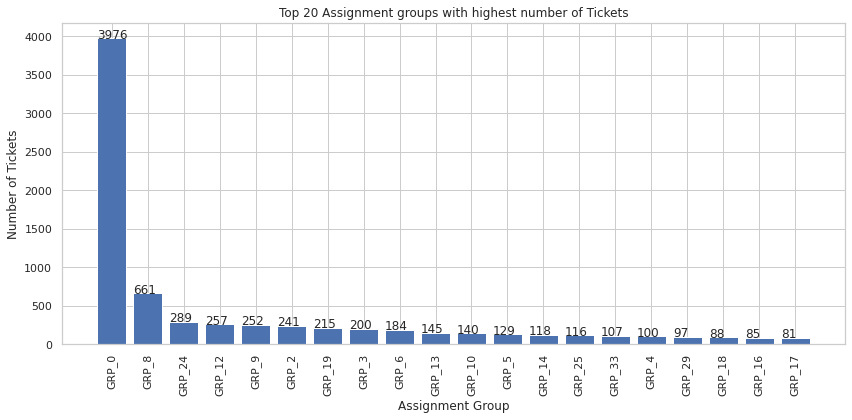

In [16]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_top_20['index'],df_top_20['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [17]:
df_bottom_20 = df_incidents['Assignment group'].value_counts().nsmallest(20).reset_index()
df_bottom_20

,index,Assignment group
0,GRP_61,1
1,GRP_64,1
2,GRP_67,1
3,GRP_35,1
4,GRP_70,1
5,GRP_73,1
6,GRP_57,2
7,GRP_54,2
8,GRP_69,2
9,GRP_71,2


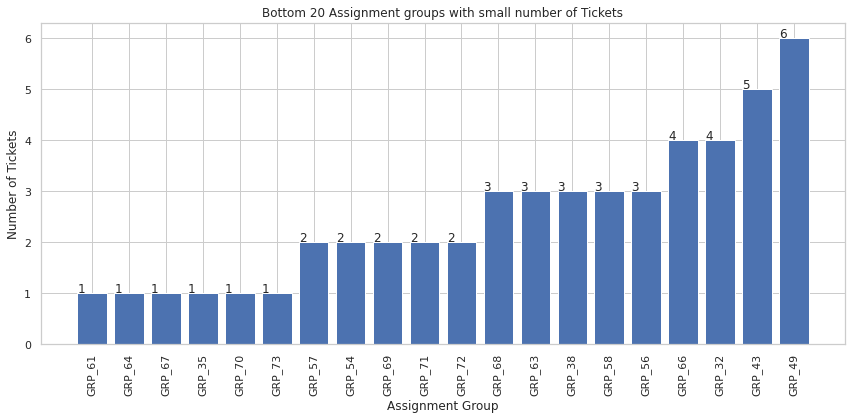

In [18]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_bottom_20['index'],df_bottom_20['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [19]:
df_bins = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1 ticket','Ticket Count':len(df_inc[df_inc['Assignment group'] < 2])}
_2_5_ticket = {'Description':'2-5 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 1)& (df_inc['Assignment group'] < 6) ])}
_10_ticket = {'Description':' 6-10 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 5)& (df_inc['Assignment group'] < 11)])}
_10_20_ticket = {'Description':' 11-20 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 10)& (df_inc['Assignment group'] < 21)])}
_20_50_ticket = {'Description':' 21-50 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 20)& (df_inc['Assignment group'] < 51)])}
_51_100_ticket = {'Description':' 51-100 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 50)& (df_inc['Assignment group'] < 101)])}
_100_ticket = {'Description':' >100 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 100)])}
#append row to the dataframe
df_bins = df_bins.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

df_bins

,Description,Ticket Count
0,1 ticket,6
1,2-5 ticket,13
2,6-10 ticket,6
3,11-20 ticket,9
4,21-50 ticket,16
5,51-100 ticket,9
6,>100 ticket,15


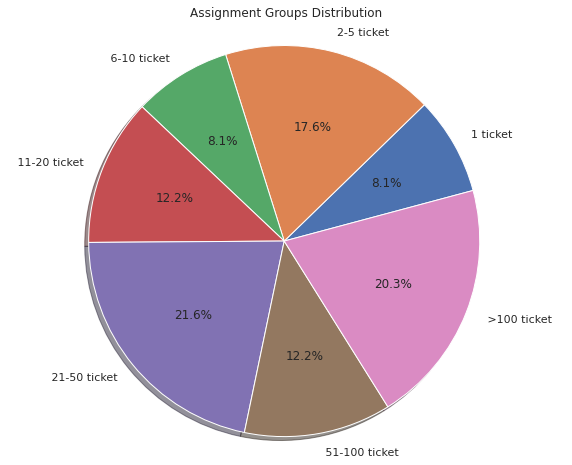

In [20]:
plt.figure(figsize=(10, 8))
plt.pie(df_bins['Ticket Count'],labels=df_bins['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution')
plt.axis('equal');

We see that there are 6 Assignment Group’s for which just have 1 ticket in the dataset
There are 15 Assignment group’s which have more than 100 tickets.
Only 20% of the Assignment groups have greater than 100 tickets.

In [21]:
#check if the data has any missing values
df_incidents[df_incidents['Short description'].isnull()]

,Short description,Description,Assignment group
2604,NaN,_x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...,GRP_34
3383,NaN,_x000D_\n-connected to the user system using t...,GRP_0
3906,NaN,-user unable tologin to vpn._x000D_\n-connect...,GRP_0
3910,NaN,-user unable tologin to vpn._x000D_\n-connect...,GRP_0
3915,NaN,-user unable tologin to vpn._x000D_\n-connect...,GRP_0
3921,NaN,-user unable tologin to vpn._x000D_\n-connect...,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,GRP_0
4341,NaN,_x000D_\n_x000D_\nreceived from: eqmuniov.ehxk...,GRP_0


In [22]:
df_incidents[df_incidents['Description'].isnull()]

,Short description,Description,Assignment group
4395,i am locked out of skype,NaN,GRP_0


Lets replace nan values with '' (empty string)
And then concatenate Short Description and Description to form a single column named 'New_Description' and use it as a predictor. so that we won't miss any necessary info about the ticket.

In [23]:
#Replace NaN values in Short Description and Description columns
df_incidents['Short description'] = df_incidents['Short description'].replace(np.nan, '', regex=True)
df_incidents['Description'] = df_incidents['Description'].replace(np.nan, '', regex=True)

In [24]:
df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8500 non-null   object
 1   Description        8500 non-null   object
 2   Assignment group   8500 non-null   object
dtypes: object(3)
memory usage: 199.3+ KB


In [25]:
#Concatenate Short Description and Description columns
df_incidents['New_Description'] = df_incidents['Short description'] + ' ' +df_incidents['Description']

In [26]:
df_incidents.head()

,Short description,Description,Assignment group,New_Description
0,login issue,-verified user details.(employee# & manager na...,GRP_0,login issue -verified user details.(employee# ...
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,GRP_0,outlook _x000D_\n_x000D_\nreceived from: hmjdr...
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,GRP_0,cant log in to vpn _x000D_\n_x000D_\nreceived ...
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0,unable to access hr_tool page unable to access...
4,skype error,skype error,GRP_0,skype error skype error


In [27]:
def f_word_cloud(column):
    
    comment_words = ' '
    stopwords = set(STOPWORDS)

    # iterate through the csv file 
    for val in column: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
    
    return wordcloud

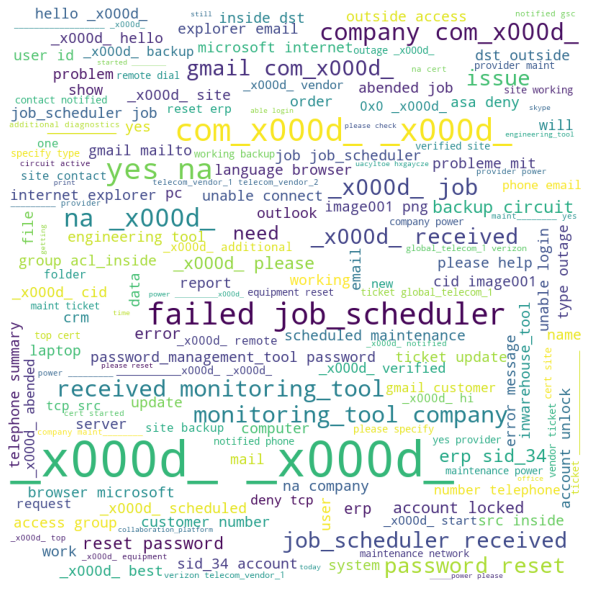

In [28]:
wordcloud = f_word_cloud(df_incidents.New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

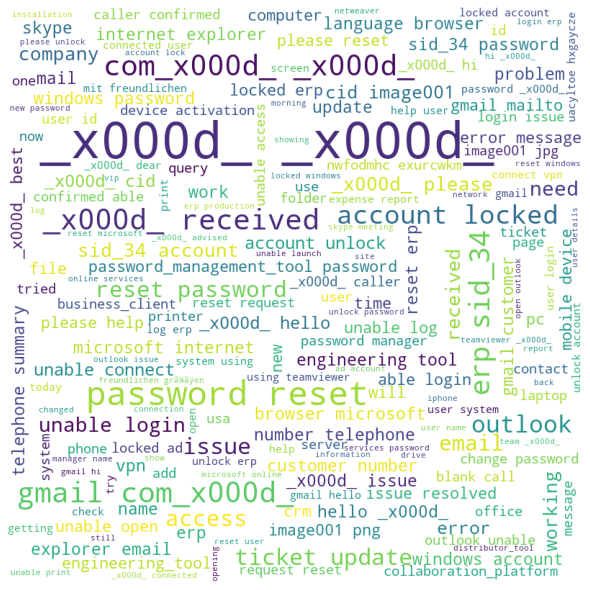

In [29]:
wordcloud = f_word_cloud(df_incidents[df_incidents['Assignment group']=='GRP_0'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

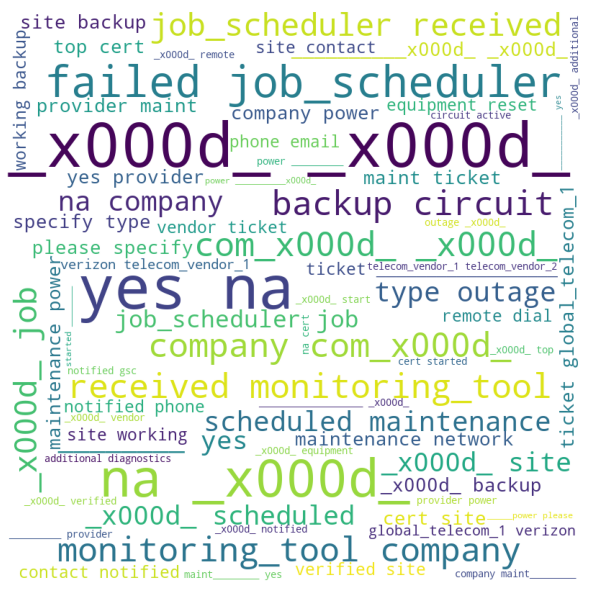

In [30]:
wordcloud = f_word_cloud(df_incidents[df_incidents['Assignment group']=='GRP_8'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show()

GRP_8 seems to have tickets related to outage, job failures, etc

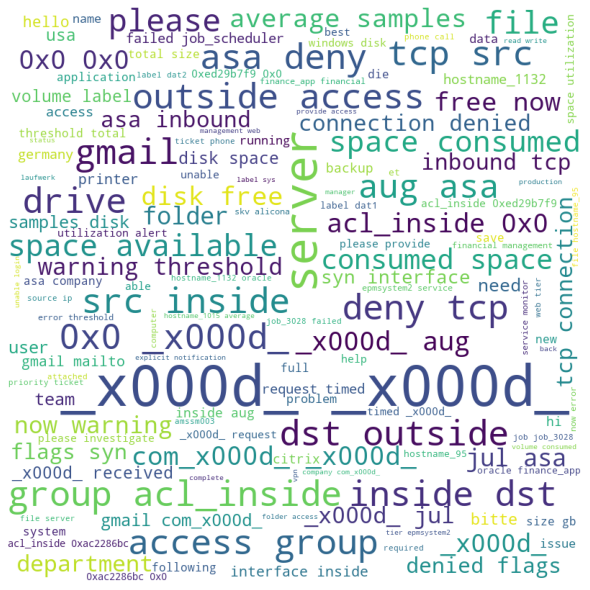

In [31]:
wordcloud = f_word_cloud(df_incidents[df_incidents['Assignment group']=='GRP_12'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

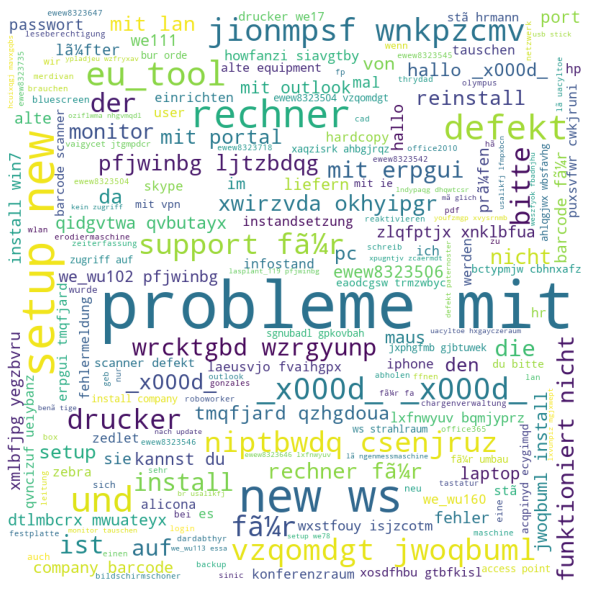

In [32]:
wordcloud = f_word_cloud(df_incidents[df_incidents['Assignment group']=='GRP_24'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_24 - Tickets are mainly in german, these tickets need to be translated to english before passing it to our model.

In [33]:
df_incidents[df_incidents['Assignment group']=='GRP_24'].New_Description

222     support fÃ¼r fa.gstry \arexjftu ohxdwngl suppo...
223     probleme mit bluescreen . hallo ,\n\nes ist er...
255     probleme mit laufwerk z: \laeusvjo fvaihgpx pr...
302     EU_tool ist sehr langsadgtym \ywqgrbnx jwnsyzb...
304     alte eq abholen \wrcktgbd wzrgyunp alte eq abh...
                              ...                        
8413    pobleme mit we_combi \jionmpsf wnkpzcmv poblem...
8414    langsamer rechner \Ã¼berprÃ¼fung \niptbwdq cse...
8416    setup new ws \kebogxzp difnjlkp  setup new ws ...
8417    bluetooth keybankrd defekt \dardabthyr bluetoo...
8419    probleme mit bildschirmschoner \ we91 \jionmps...
Name: New_Description, Length: 289, dtype: object

In [34]:
#Lets encode the string, to make it easier to be passed to language detection api.
def fn_decode_to_ascii(df):
  text = df.encode().decode('utf-8').encode('ascii', 'ignore')
  return text.decode("utf-8") 

df_incidents['New_Description'] = df_incidents['New_Description'].apply(fn_decode_to_ascii)

In [35]:
# Language id for each description
langids = df_incidents['New_Description'].apply(langid.classify)
# Gets the language label alone
df_incidents['Language'] = langids.apply(lambda tuple : tuple[0])

In [36]:
df_incidents["Language"].value_counts()

en    7259
de     515
fr     180
br      84
nb      66
it      52
nl      43
es      33
da      33
ro      22
af      22
sw      20
pt      17
mt      15
eu      14
no      10
pl       9
cy       8
rw       8
lv       8
lb       7
sv       7
qu       6
id       5
ca       5
ht       4
fi       4
tl       4
nn       3
hr       3
oc       3
lt       3
zu       3
gl       2
fo       2
ms       2
jv       2
bs       2
et       2
se       2
an       2
sl       2
sq       2
tr       1
mg       1
xh       1
zh       1
hu       1
Name: Language, dtype: int64

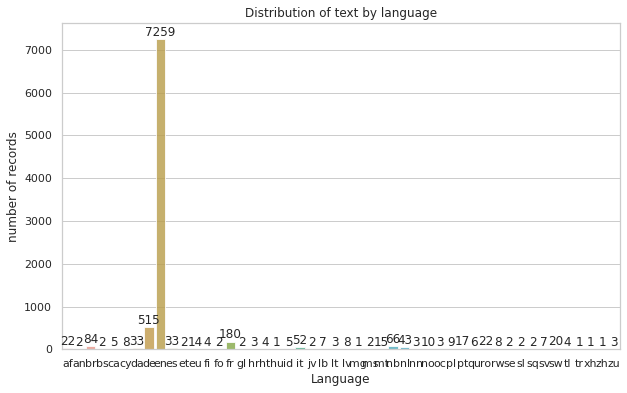

In [37]:
x = df_incidents["Language"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

We can see that most of the tickets are in english, followed by tickets in German language. We need to translate these into english.

In [38]:
df_incidents[df_incidents["Short description"].str.contains("account lock")]["Assignment group"].value_counts()

GRP_0     226
GRP_2       3
GRP_34      1
GRP_72      1
Name: Assignment group, dtype: int64

In [39]:
df_incidents[df_incidents["Short description"].str.contains("oneteam")]["Assignment group"].value_counts()

GRP_0     3
GRP_73    1
Name: Assignment group, dtype: int64

In [40]:
df_incidents.head()

,Short description,Description,Assignment group,New_Description,Language
0,login issue,-verified user details.(employee# & manager na...,GRP_0,login issue -verified user details.(employee# ...,en
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,GRP_0,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,en
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,GRP_0,cant log in to vpn _x000D_\n_x000D_\nreceived ...,en
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0,unable to access hr_tool page unable to access...,en
4,skype error,skype error,GRP_0,skype error skype error,da


#### Data Pre-Processing

In [41]:
df = pd.DataFrame({ 
    "Description": df_incidents['New_Description'], 
    "Group": df_incidents['Assignment group'],
    "Detected Language": df_incidents['Language']}, columns=["Description", "Group", "Detected Language"])

In [42]:
df.head()

,Description,Group,Detected Language
0,login issue -verified user details.(employee# ...,GRP_0,en
1,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,GRP_0,en
2,cant log in to vpn _x000D_\n_x000D_\nreceived ...,GRP_0,en
3,unable to access hr_tool page unable to access...,GRP_0,en
4,skype error skype error,GRP_0,da


In [43]:
print('Number of detected languages in our dataset :', df['Detected Language'].nunique())
print('Below are these languages:\n', df['Detected Language'].unique())

Number of detected languages in our dataset : 48
Below are these languages:
 ['en' 'da' 'fr' 'it' 'nb' 'br' 'lt' 'ca' 'es' 'de' 'sv' 'lb' 'eu' 'nl'
 'sq' 'no' 'af' 'sl' 'lv' 'pl' 'id' 'an' 'se' 'mg' 'jv' 'ht' 'fi' 'sw'
 'rw' 'cy' 'ro' 'tl' 'qu' 'zu' 'mt' 'et' 'bs' 'tr' 'fo' 'pt' 'hr' 'xh'
 'zh' 'gl' 'nn' 'ms' 'oc' 'hu']


In [44]:
# Conversion of other languages to English using Google Translator API
translated_desc = []
translator = google_translator()

for index, row in df.iterrows():
    newrow = copy.deepcopy(row)
    try:
        translation = translator.translate(row['Description'], lang_src=row['Detected Language'], lang_tgt='en')
        newrow['Translated'] = translation.text
    except Exception:
        newrow['Translated'] = row['Description']
    translated_desc.append(newrow['Translated'])
    # print(index)

KeyboardInterrupt: ignored

In [ ]:
# Creating a new dataframe after translation
translated_df = df.copy()
translated_df['Translated Description'] = pd.Series(translated_desc)

In [ ]:
translated_df.head()

In [ ]:
# Language id for each translated description
langids_translated = translated_df['Translated Description'].apply(langid.classify)
# Gets the language label alone
langs_after_trans = langids_translated.apply(lambda tuple : tuple[0])

print('Number of detected languages in our dataset :', langs_after_trans.nunique())
print('Below are these languages:\n', langs_after_trans.unique())

We can see that even after applying the translation, other languages still remain same. Hence we are deciding to proceed with this dataset for our further model building

#### Clean up the Description column

* Normalizing Text (Convert each character in a sentence to lowercase character)
* Remove email
* Remove underscore
* Remove HTML Tags
* Remove numbers
* Remove new line characters
* Remove hyperlinks
* Remove punctuations
* Remove stopwords
* Remove common words
* Lemmatization
* Convert multiple spaces to a single space

In [ ]:
import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_text(text):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = pos_tag(word_tokenize(text))  
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            
            #if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_text)

In [ ]:
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

In [ ]:
def cleaning_data(text):
    
    # Normaizing Text
    text = text.lower()

    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:", ' ', text)
    text = re.sub(r"from:", ' ', text)
    text = re.sub(r"to:", ' ', text)
    text = re.sub(r"subject:", ' ', text)
    text = re.sub(r"sent:", ' ', text)
    text = re.sub(r"ic:", ' ', text)
    text = re.sub(r"cc:", ' ', text)
    text = re.sub(r"bcc:", ' ', text)
    text = re.sub(r"_x000D_", ' ', text)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split()) # Remove unreadable characters  (also extra spaces)

    # Remove email 
    text = re.sub(r'\S*@\S*\s?', ' ', text)

    # Remove underscore
    desc = re.sub(r'_', ' ', text) 
    
    # Remove HTML tags 
    text = re.sub(re.compile('<.*?>'), ' ', text)
    
    text = re.sub(r'\&\w*;', ' ', text)
    
    # Remove numbers 
    text = re.sub(r'\d+', ' ', text)
    
    # Remove new line characters 
    text = re.sub(r'\n', ' ', text)
    
    # Removing hyperlinks
    text = re.sub(r'http.+?:\/\/.*\/\w*', ' ', text)
    
    # Removing punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    text = " ".join(w.translate(table) for w in word_tokenize(text))
    
    # Removing stopwords
    stop_words = stopwords.words('english')
    text = " ".join(word for word in text.split(' ') if word not in stop_words)
    
    # Lemmatization
    text = lemmatize_text(text)

    # Convert multiple spaces to a single space
    text = re.sub(r' {2,}', " ", text, flags=re.MULTILINE) 
    
    # Remove pre/post spaces
    text = text.strip()
    
    return text

In [ ]:
translated_df['Cleaned Description'] = translated_df['Translated Description'].apply(cleaning_data)

In [ ]:
df = pd.DataFrame({ 
    "Description": translated_df['Cleaned Description'], 
    "Assignment group": translated_df['Assignment group']}, columns=["Description", "Assignment group"])

In [ ]:
df.head()

## Vectorization

In [49]:
from google.colab import drive

In [50]:
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
embeddings_index = {}
f = open('/content/drive/My Drive/Great Learning/Projects/NLP/glove.6B.100d.txt', encoding="utf8")
#f = open('/content/drive/My Drive/Great Learning/Projects/NLP/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [53]:
embeddings_index.keys()

Output hidden; open in https://colab.research.google.com to view.

In [54]:
embeddings_index['login']

array([-0.90907 ,  0.29594 ,  0.1473  , -0.41327 ,  0.054759, -0.10592 ,
       -0.59419 ,  0.21344 ,  0.94355 , -0.28571 ,  0.21469 ,  0.33079 ,
        0.44375 , -0.30282 , -0.080723,  0.16201 ,  1.0703  , -0.66267 ,
       -0.10595 , -0.068358, -0.99958 , -0.92376 , -0.059927,  0.36211 ,
       -0.38552 , -0.89266 ,  0.12297 ,  0.8144  ,  0.064704, -0.492   ,
        0.67006 ,  0.80839 ,  0.45485 , -0.18486 ,  0.78549 , -0.37607 ,
       -0.86583 , -0.31026 ,  0.12632 , -0.20537 ,  0.6703  , -0.51899 ,
        0.31974 ,  0.20362 , -0.51707 ,  0.65196 , -0.71614 , -0.33318 ,
        0.023626,  0.018663,  0.26647 ,  0.52255 , -0.020652,  0.62328 ,
        0.1374  , -0.040994,  0.18668 , -0.35269 , -0.33691 , -0.12065 ,
       -0.49665 ,  0.22225 , -0.45156 ,  0.81232 ,  0.48352 , -0.40804 ,
       -0.2321  , -0.87179 ,  0.44785 , -0.34731 , -0.71127 ,  0.48481 ,
        0.7532  , -0.70953 , -0.79626 ,  0.88131 , -1.0639  , -0.51368 ,
        0.28329 , -0.49795 ,  0.37716 , -0.18027 , 

In [55]:
embeddings_index['issue']

array([-3.3126e-01,  3.5314e-02,  5.9881e-01,  1.4438e-01,  8.7857e-02,
       -2.3078e-01, -7.8876e-03, -5.7724e-01,  7.5547e-01, -3.0510e-01,
       -6.4974e-03,  2.3473e-01,  2.0424e-01, -7.6290e-03, -3.4221e-01,
       -1.1881e-01,  2.0439e-01,  7.1652e-02, -2.4928e-01, -8.9414e-01,
        5.4334e-01, -4.8583e-01,  8.2513e-02,  1.0531e-01,  3.1343e-01,
       -4.7411e-02,  3.2675e-01, -3.6492e-01, -4.4649e-01,  4.5387e-01,
       -1.4689e-01,  2.2646e-01,  4.5376e-01,  4.0626e-01, -4.7647e-01,
        6.0960e-01,  1.5961e-01, -1.1480e-01, -4.3358e-01, -1.5999e-02,
       -7.7636e-01, -4.7432e-01,  5.0372e-01, -7.9097e-01, -7.8178e-01,
       -6.7845e-01,  6.0212e-02, -2.4419e-01, -7.5732e-01, -8.2025e-01,
        8.3479e-01, -1.1802e-01,  8.7791e-02,  1.3345e+00, -3.2742e-01,
       -2.1275e+00,  3.7674e-01, -5.6629e-01,  1.8865e+00,  3.4309e-01,
       -5.7656e-02,  4.9458e-01, -3.8238e-01, -5.6819e-01,  1.5391e+00,
       -2.3591e-01,  1.3009e-01,  6.7913e-01,  3.1525e-01,  6.80

In [59]:
from nltk.tokenize import RegexpTokenizer
def tokenize(comp):
    
    words = RegexpTokenizer('\w+').tokenize(comp)
    words = [re.sub(r'([xx]+)|([XX]+)|(\d+)', '', w).lower() for w in words]
    words = list(filter(lambda a: a != '', words))
    
    return words

In [73]:
X = df['Description']
Y = df['Group']

In [66]:
embeddings = list()
for comp in X:
    sentence = np.zeros(100)
    count = 0
    for w in tokenize(comp):
        try:
            count += 1
            embeddingValue = embeddings_index[w]
            if(np.isnan(np.sum(embeddingValue))):
              print('NAN Skipped !!!')
              continue
            else:
              sentence += embeddingValue
        except KeyError:
            continue
    
    if(count==0):
      embeddings.append(sentence)
    else:
      embeddings.append(sentence / count)

In [67]:
len(embeddings)

8500

In [68]:
len(embeddings[0])

100

In [69]:
len(X[0])

242

In [70]:
X[0]

'login issue -verified user details.(employee# & manager name)_x000D_\n-checked the user name in ad and reset the password._x000D_\n-advised the user to login and check._x000D_\n-caller confirmed that he was able to login._x000D_\n-issue resolved.'

In [71]:
embeddings[0]

array([-0.187302  , -0.09796938,  0.28530544, -0.13038867, -0.00347339,
        0.10974566, -0.12165798,  0.03715626,  0.23046554,  0.08386536,
        0.11495342,  0.12005093,  0.38243203, -0.14567765,  0.04444405,
       -0.10960921,  0.40853064, -0.01347128, -0.34874538, -0.03002059,
       -0.10567498, -0.26862968,  0.02284241,  0.08245228, -0.00643956,
       -0.31868003, -0.00174244, -0.16510461, -0.01898662, -0.12244759,
        0.06192838,  0.56733905, -0.02856015,  0.20424656,  0.12875874,
        0.2003582 , -0.2243    ,  0.02399605,  0.05992613, -0.19242751,
       -0.17140271, -0.19776961,  0.17171474, -0.21779982, -0.19103649,
        0.11879552, -0.04117228, -0.35022373,  0.02087567, -0.52953405,
        0.22280582,  0.16577416,  0.18447087,  0.79626564, -0.16414739,
       -1.52152422, -0.1097019 , -0.3461489 ,  1.09643503,  0.36582   ,
       -0.10761751,  0.42296292, -0.19299127,  0.18044202,  0.71615247,
       -0.14835314,  0.23143641,  0.1511153 ,  0.27159326, -0.07

In [72]:
array_sum = np.sum(embeddings)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings), Y, 
    test_size=0.20, random_state=0)

In [78]:
X_train.shape[0]

6800

In [79]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6800, 100)
(6800,)
(1700, 100)
(1700,)
